# Benchmark of NTR (nascent to total ratio)

This notebook analysis the NTR of genes

In [1]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Benchmark of NTR (scatter)

In [2]:
d = pd.read_csv("../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.2TC.tsv", sep="\t", header=0, index_col=0)
d["NTR"] = d["Nascent"] / d["Total"]
d = d[d["Total"] >= 50]
d1 = d

d = pd.read_csv("../../2_NASCseq/reports/halflife_NASCseq_K562_50uM_3h.tsv", sep="\t")
d["NTR"] = d["Count.Nascent"] / d["Count"]
d = d[(d["Canonical"]) & (d["GeneType"] == "protein_coding") & (d["Count"] >= 200)]
d = d[~d["GeneID"].duplicated()]
d.index = d["GeneID"]
d2 = d

d = pd.read_csv("../../2_NASCseq/reports/halflife_GSE128273_K562_50uM_3h.tsv", sep="\t")
d["NTR"] = d["Count.Nascent"] / d["Count"]
d = d[(d["Canonical"]) & (d["GeneType"] == "protein_coding") & (d["Count"] >= 200)]
d = d[~d["GeneID"].duplicated()]
d.index = d["GeneID"]
d3 = d

print(len(d1), len(d2), len(d3), sep="\t")

2412	7369	9658


In [3]:
s1 = d1["NTR"]
s1.name = "FLAIR-seq"

s2 = d2["NTR"]
s2.name = "NASC-seq"

s3 = d3["NTR"]
s3.name = "NASC-seq.GSE128273"

m = pd.concat([s1, s2, s3], axis=1, join="inner").fillna(0)

0.8186932866588326
0.7340726157298265
0.8008165472260758


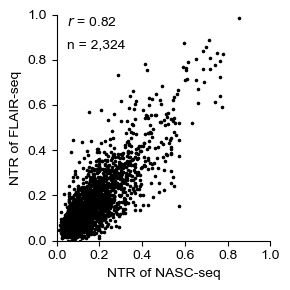

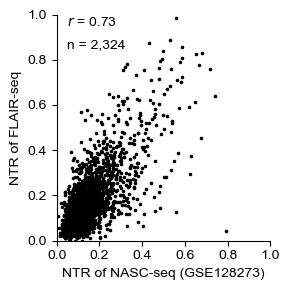

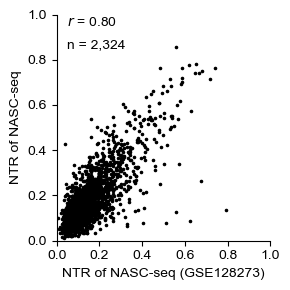

In [4]:
params = [
    ["NASC-seq", "FLAIR-seq", "NTR of NASC-seq", "NTR of FLAIR-seq"],
    ["NASC-seq.GSE128273", "FLAIR-seq", "NTR of NASC-seq (GSE128273)", "NTR of FLAIR-seq"],
    ["NASC-seq.GSE128273", "NASC-seq", "NTR of NASC-seq (GSE128273)", "NTR of NASC-seq"],
]

for name1, name2, label1, label2 in params:
    xs = m[name1]
    ys = m[name2]
    r = np.corrcoef(xs, ys)[0][1]
    print(r)

    plt.figure(figsize=(3, 3))
    plt.scatter(xs, ys, marker=".", s=10, color="black")
    # sns.kdeplot(x=xs, y=ys, fill=True, cmap='Blues', cbar=False, alpha=1, zorder=2)
    # plt.plot([0, 1], [0, 1], lw=1, ls="--", color="grey")
    plt.text(0.05, 0.95, "$\it{r}$ = %.2f" % r)
    plt.text(0.05, 0.85, "n = %s" % format(len(xs), ","))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.tight_layout()
    plt.savefig("figures/correlation_of_ntr.%s_vs_%s.pdf" % (name1, name2))

## 2. NTR of case genes (barplot)

    MYC, PDLIM5, GAPDH

In [5]:
d = pd.read_csv("../../1_FLAIRseq/reports/FLAIRseq_Summary.tsv", sep="\t")
df = d[(d["CellLine"] == "K562") & (d["ActD"].isna()) & (d["Time"] == 3) & (d["UMIs"] >= 5000)]
df1 = df[(df["s4U"] == 0)]
df2 = df[(df["s4U"] == 50) & (df["TC.Ratio"] >= 0.00) & (df["TC.Ratio"] < 0.02)]
print(len(df1), len(df2))
df_list = [df1, df2]
m_list = []

for df in df_list:
    array1 = []
    array2 = []
    for run, cell in df[["Run", "Cell"]].values:
        path = "../../1_FLAIRseq/results/expression/quant_genes/min_read_2_min_tc_2/%s/%s.tsv" % (run, cell)
        if os.path.exists(path):
            d = pd.read_csv(path, sep="\t", header=0, index_col=0)
            s1 = d["Total"]
            s1.name = cell
            s2 = d["Nascent"]
            s2.name = cell
            array1.append(s1)
            array2.append(s2)        
    s1 = pd.concat(array1, axis=1).fillna(0).sum(axis=1)
    s1.name = "Total"
    s2 = pd.concat(array2, axis=1).fillna(0).sum(axis=1)
    s2.name = "Nascent"
    m = pd.concat([s1, s2], axis=1).fillna(0)
    m_list.append(m)

190 173


ENSG00000136997.21	343.0	0.0	0.0
ENSG00000163110.15	114.0	0.0	0.0
ENSG00000111640.15	7593.0	6.0	0.07902015013828527
ENSG00000136997.21	21.0	19.0	90.47619047619048
ENSG00000163110.15	74.0	8.0	10.81081081081081
ENSG00000111640.15	8169.0	462.0	5.655526992287918


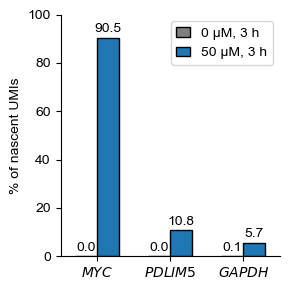

In [6]:
items = [
    ["MYC", "ENSG00000136997.21"],
    ["PDLIM5", "ENSG00000163110.15"],
    ["GAPDH", "ENSG00000111640.15"],
    #["ACTB", "ENSG00000075624.17"],
    #["RPL11", "ENSG00000142676.14"],
    #["YTHDF2", "ENSG00000198492.16"],
    # ["MALAT1", "ENSG00000251562.9"]
]
genes = [item[0] for item in items]
gids = [item[1] for item in items]

rows = []
for m in m_list:
    row = []
    for gid in gids:
        v1, v2 = m.loc[gid]
        r = v2 * 100 / v1
        print(gid, v1, v2, r, sep="\t")
        row.append(r)
    rows.append(row)
m = np.array(rows)

xs = np.arange(len(genes))
w = 0.3
labels = ["0 μM, 3 h", "50 μM, 3 h"]

plt.figure(figsize=(3, 3))
for i in range(2):
    xs1 = xs + i * w - w / 2
    ys1 = m[i]
    plt.bar(xs1, ys1, width=w, edgecolor="black", color=["C7", "C0"][i], label=labels[i])
    for x, y in zip(xs1, ys1):
        plt.text(x, y + 1, "%.1f" % y, ha="center", va="bottom")
plt.xticks(xs, ["$\it{%s}$" % g for g in genes])
plt.ylabel("% of nascent UMIs")
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 100)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(handlelength=1)
plt.tight_layout()
plt.savefig("figures/nascent_rna_proportion.marker_genes.pdf")

## 3. Make bam for IGV

In [91]:
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
df = d[(d["Strain"] == "K562") & (d["ActD"].isna()) & (d["Time"] == 3) & (d["UMIs"] >= 5000)]
df1 = df[(df["s4U"] == 0)]
df2 = df[(df["s4U"] == 50) & (df["TCRatio"] >= 0.00) & (df["TCRatio"] < 0.02)]
print(len(df1), len(df2))

190 173


In [110]:
import pysam
import subprocess

locs = [
    ["chr8", 127735000, 127744000, "MYC"],
    ["chr1", 28735000, 28770000, "YTHDF2"]
]

for loc in locs:
    fw = None
    bamfile = "results/K562_%s.0uM3h.bam" % loc[3]
    bamfile2 = "results/K562_%s.0uM3h.sorted.bam" % loc[3]
    for run, cell in df1[["Run", "Cell"]].values:
        path = "../../1_NanoNASCseq/results/mismatch/events/%s/%s.bam" % (run, cell)
        with pysam.AlignmentFile(path) as f:
            if fw is None:
                fw = pysam.AlignmentFile(bamfile, "wb", f)
            segments = defaultdict(list)
            for s in f.fetch(loc[0], loc[1], loc[2]):
                segments[s.get_tag("CN")].append(s)
            for k, v in segments.items():
                if len(v) > 1:
                    v = v[:min(len(v), 3)]
                    for s in v:
                        fw.write(s)     
    subprocess.check_call("samtools sort -o %s %s" % (bamfile2, bamfile), shell=True)
    subprocess.check_call("samtools index %s" % bamfile2, shell=True)

    fw = None
    bamfile = "results/K562_%s.50uM3h.bam" % loc[3]
    bamfile2 = "results/K562_%s.50uM3h.sorted.bam" % loc[3]
    for run, cell in df2[["Run", "Cell"]].values:
        path = "../../1_NanoNASCseq/results/mismatch/events/%s/%s.bam" % (run, cell)
        with pysam.AlignmentFile(path) as f:
            if fw is None:
                fw = pysam.AlignmentFile(bamfile, "wb", f)
            segments = defaultdict(list)
            for s in f.fetch(loc[0], loc[1], loc[2]):
                segments[s.get_tag("CN")].append(s)
            for k, v in segments.items():
                if len(v) > 1:
                    v = v[:min(len(v), 3)]
                    for s in v:
                        fw.write(s)       
    subprocess.check_call("samtools sort -o %s %s" % (bamfile2, bamfile), shell=True)
    subprocess.check_call("samtools index %s" % bamfile2, shell=True)

0